### Demo SURE-CNN for HSI denoising
- Simulated data are created (using Matlab) and stored in folder **hsi_data**
- A matlab file (e.g. sigma50eta0dc.mat) has: img--> clean image, img_noisy --> noisy image; sigma2 --> estimated sigma by Wavelet

In [1]:
# mount the drive, the files are stored in /content/drive/MyDrive/HSI_Denoising_SURE_CNN-master
# stdlib
import os

# external
from google.colab import drive

drive.mount("/content/drive/")
folder = "/content/drive/MyDrive/HSI_Denoising_SURE_CNN-master"
# check whether the folder exists
print(os.path.exists(folder))

Mounted at /content/drive/
True


In [ ]:
# change directoder to the folder
%cd $folder

/content/drive/MyDrive/HSI_Denoising_SURE_CNN-master


In [ ]:
# stdlib
import os

# external
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

# import the libraries required
import tensorflow as tf
from models.skipnet import *
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.common import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

(400, 200, 103)


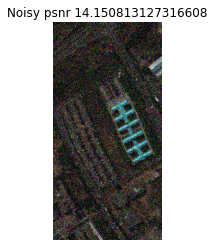

In [ ]:
# load dataset, the one used is from Pavia University
dname = "sigma50eta0PaviaU"
fname = "hsi_data/Demo/" + dname + ".mat"
data = sio.loadmat(fname)

# create clean image numpy array of type float
img_clean_np = data["image"].astype(np.float32)
# get the shape of the dataset (400, 200, 103)
print(img_clean_np.shape)

# create noisy image numpy array of type float
img_noisy_np = data["image_noisy"].astype(np.float32)
sigmaest = data["sigma2"].astype(
    np.float32
)  # estimated sigma by Wavelet (sigma2) or HySime (sigma1)
# sigma=data['noiselev'].astype(np.float32) #True sigma (but unknow in practice)

# show the band 57, 27, 17
showband = [57, 27, 17]
plt.imshow(np.clip(img_noisy_np[:, :, showband], 0, 1))
# plt.imshow(img_clean_crop[:,:,showband])
plt.title("Noisy psnr " + str(psnr(img_clean_np, img_noisy_np)))
plt.axis("off")
plt.show()

# reshape the images to (1, 400, 200, 103)
img_noisy = img_noisy_np.reshape(
    1, img_noisy_np.shape[0], img_noisy_np.shape[1], img_noisy_np.shape[2]
)
img_clean = img_clean_np.reshape(
    1, img_clean_np.shape[0], img_clean_np.shape[1], img_clean_np.shape[2]
)

In [ ]:
print(sigmaest.shape)

(103, 1)


Save model in *__filepath__*

In [ ]:
sure = True
if sure:
    filepath = "./results/best model/Demo/" + "sure" + dname + ".hdf5"
else:
    filepath = "./results/best model/Demo/" + "dip" + dname + ".hdf5"

In [ ]:
print(filepath)

./results/best model/Demo/suresigma50eta0PaviaU.hdf5


In [ ]:
# Define model
mymodel = skip(ndown=5, channel=img_noisy.shape[-1])
lr = 0.001
myoptimizer = tf.keras.optimizers.Adam(lr)
num_epochs = 50
loss_object = tf.keras.losses.MeanSquaredError()

In [ ]:
# Calculate gradient
@tf.function
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value, div_value = losshyper(
            model, inputs, targets, sigma=sigmaest, sure=sure
        )
    return loss_value, div_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# display model summary
mymodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 103)]                                                            
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   118784      ['input_1[0][0]']                
                                128)                                                              
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, None, None,   0           ['conv2d[0][0]']                 
                                128)                                                          

Training and save only best model (interm of PSNR)
- train_loss_results: Training loss which is expected closed to true_mse
- true_mse: MSE between denoised image and reference image
- train_div_results: divergence term in SURE formula

In [ ]:
# start training
train_loss_results = []
train_div_results = []
denoised_psnr = []
curr_psnr = 0
# for loop for going through each epoch
for epoch in range(num_epochs):
    if sure:
        loss_label = "SURE"
        # get gradient for the current model
        loss_value, div_value, grads = grad(mymodel, img_noisy, img_noisy)
        # apply gradient to the optimizer
        myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
        img_out = mymodel.predict(img_noisy)
        # if the pnsr between the clean image and the output from the model is higher than the previous output, save the current model
        if psnr(img_clean_np, img_out[0]) > curr_psnr:
            tf.keras.models.save_model(mymodel, filepath)
            curr_psnr = psnr(img_clean_np, img_out[0])
        print("This is running epoch %d and Loss %f" % (epoch, loss_value))
        print(
            "Iteration %05d    Loss %f     PSNR %f"
            % (epoch, loss_value, psnr(img_clean_np, img_out[0])),
            "\r",
            end="",
        )
        # updating loss, div, psnr
        train_loss_results.append(loss_value)
        train_div_results.append(div_value)
        denoised_psnr.append(psnr(img_clean_np, img_out[0]))

    else:
        loss_label = "DIP"
        img_noisy1 = img_noisy + tf.random.normal((tf.shape(img_noisy)), 0.0, 1 / 30.0)
        loss_value, div_value, grads = grad(mymodel, img_noisy1, img_noisy)
        myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
        img_out = mymodel.predict(img_noisy1)
        if psnr(img_clean_np, img_out[0]) > curr_psnr:
            tf.keras.models.save_model(mymodel, filepath)
            curr_psnr = psnr(img_clean_np, img_out[0])

This is running epoch 0 and Loss 0.115728
This is running epoch 1 and Loss 0.099320
This is running epoch 2 and Loss 0.079388
This is running epoch 3 and Loss 0.061441
This is running epoch 4 and Loss 0.047727
This is running epoch 5 and Loss 0.038052
This is running epoch 6 and Loss 0.028979
This is running epoch 7 and Loss 0.024563
This is running epoch 8 and Loss 0.021733
This is running epoch 9 and Loss 0.019594
This is running epoch 10 and Loss 0.017933
This is running epoch 11 and Loss 0.016279
This is running epoch 12 and Loss 0.014892
This is running epoch 13 and Loss 0.013715
This is running epoch 14 and Loss 0.012868
This is running epoch 15 and Loss 0.012362
This is running epoch 16 and Loss 0.013711
This is running epoch 17 and Loss 0.015163
This is running epoch 18 and Loss 0.010499
This is running epoch 19 and Loss 0.011891
This is running epoch 20 and Loss 0.008941
This is running epoch 21 and Loss 0.010041
This is running epoch 22 and Loss 0.007814
This is running epoch

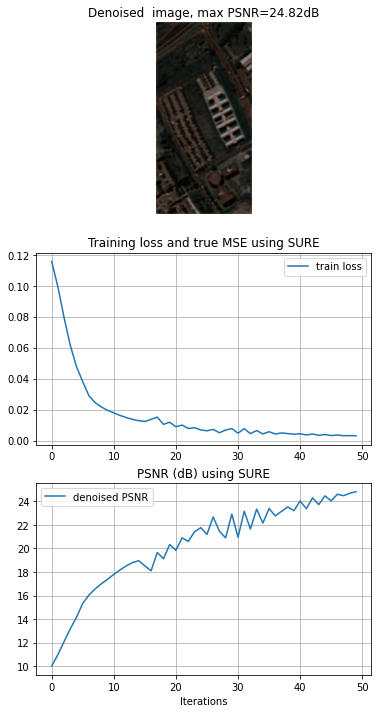

In [ ]:
# show the output image
fig1, (ax, ax1, ax2) = plt.subplots(3, sharex=False, figsize=(6, 12))
ax.imshow(np.clip(img_out[0][:, :, showband], 0, 1))
ax.set_title(
    "Denoised  image, max PSNR=" + str(np.round(np.max(denoised_psnr), 2)) + "dB"
)
ax.axis("off")
# plot train loss and divergence
ax1.plot(range(num_epochs), train_loss_results, label="train loss")
# ax1.plot(range(num_epochs),train_div_results,label="divergence")
ax1.set_title("Training loss and true MSE using " + loss_label)
ax1.legend()
ax1.grid()

# plot PSNR
ax2.plot(denoised_psnr, label="denoised PSNR")
ax2.set_xlabel("Iterations")
ax2.set_title("PSNR (dB) using " + loss_label)
ax2.legend()
ax2.grid()

In [ ]:
# set the model to load the trained model
PUbestmodel = tf.keras.models.load_model(filepath)
# pass the noisy image into the model to get the output from the trained model
out_best = PUbestmodel.predict(img_noisy)

In [ ]:
# function for calculating mean ssim (Structural Similarity Index)
def meanssim(X, Y):
    bandssim = []
    for i in range(X.shape[2]):
        bandssim.append(
            ssim(
                X[:, :, i],
                Y[:, :, i],
                data_range=1.0,
                K1=0.01,
                K2=0.03,
                gaussian_weights=True,
                sigma=1.5,
                use_sample_covariance=False,
            )
        )
    return np.mean(bandssim)

In [ ]:
# print PSNR and Mean SSIM for SURE
print(psnr(img_clean_np, out_best[0]))
print(meanssim(img_clean_np, out_best[0]))

24.822174041724956
0.697292117233552


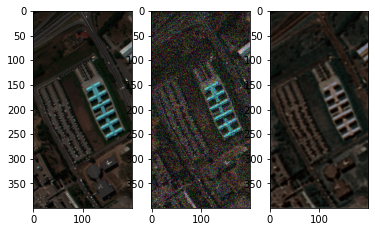

In [ ]:
# show the images (clean, noisy, output from the trained model)
plt.subplot(131)
plt.imshow(img_clean_np[:, :, showband])
plt.subplot(132)
plt.imshow(np.clip(img_noisy_np[:, :, showband], 0, 1))
plt.subplot(133)
plt.imshow(out_best[0][:, :, showband])
plt.show()

In [ ]:
# sio.savemat("./results/DL_Compare/"+dname+".mat",mdict={"xsure":out_best[0],"xnoise":img_noisy_np,"x":img_clean_np})

In [ ]:
# np.save("sureloss100",train_loss_results)
# np.save("suretrue100",true_mse)

In [ ]:
# sureloss=np.load("sureloss100.npy")
# suretrue=np.load("suretrue100.npy")
# mseloss=np.load("mseloss100.npy")
# msetrue=np.load("msetrue100.npy")

In [ ]:
# fig10=plt.figure(figsize=(6,5))
# plt.plot(sureloss,"r--", label= "SURE loss",linewidth=2.0)
# plt.plot(suretrue,"g-.", label= "SURE true MSE",linewidth=2.0)
# plt.plot(mseloss, "k", label= "fidelity loss",linewidth=2.0)
# plt.plot(msetrue, "b",label= "fidelity true MSE",linewidth=2.0)
# # plt.ylim(ymin=-0.01,ymax=0.20)
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid()
# plt.show()
# # fig10.savefig("loss.pdf")

Now we train using DIP (Deep Image Prior)



In [ ]:
sure = False
if sure:
    filepath = "./results/best model/Demo/" + "sure" + dname + ".hdf5"
else:
    filepath = "./results/best model/Demo/" + "dip" + dname + ".hdf5"

In [ ]:
# Define model
mymodel = skip(ndown=5, channel=img_noisy.shape[-1])
lr = 0.001
myoptimizer = tf.keras.optimizers.Adam(lr)
num_epochs = 50
loss_object = tf.keras.losses.MeanSquaredError()

In [ ]:
# Calculate gradient
@tf.function
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value, div_value = losshyper(
            model, inputs, targets, sigma=sigmaest, sure=sure
        )
    return loss_value, div_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# start training DIP
train_loss_results = []
train_div_results = []
denoised_psnr = []
curr_psnr = 0
# for loop for going through each epoch
for epoch in range(num_epochs):
    if sure:
        loss_label = "SURE"
        # get gradient for the current model
        loss_value, div_value, grads = grad(mymodel, img_noisy, img_noisy)
        # apply gradient to the optimizer
        myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
        img_out = mymodel.predict(img_noisy)
        # if the pnsr between the clean image and the output from the model is higher than the previous output, save the current model
        if psnr(img_clean_np, img_out[0]) > curr_psnr:
            tf.keras.models.save_model(mymodel, filepath)
            curr_psnr = psnr(img_clean_np, img_out[0])
        print("This is running epoch %d and Loss %f" % (epoch, loss_value))
        print(
            "Iteration %05d    Loss %f     PSNR %f"
            % (epoch, loss_value, psnr(img_clean_np, img_out[0])),
            "\r",
            end="",
        )
        # updating loss, div, psnr
        train_loss_results.append(loss_value)
        train_div_results.append(div_value)
        denoised_psnr.append(psnr(img_clean_np, img_out[0]))

    else:
        loss_label = "DIP"
        img_noisy1 = img_noisy + tf.random.normal((tf.shape(img_noisy)), 0.0, 1 / 30.0)
        loss_value, div_value, grads = grad(mymodel, img_noisy1, img_noisy)
        myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
        img_out = mymodel.predict(img_noisy1)
        if psnr(img_clean_np, img_out[0]) > curr_psnr:
            tf.keras.models.save_model(mymodel, filepath)
            curr_psnr = psnr(img_clean_np, img_out[0])
            # updating loss, div, psnr
            train_loss_results.append(loss_value)
            train_div_results.append(div_value)
            denoised_psnr.append(psnr(img_clean_np, img_out[0]))
        print("This is running epoch %d and Loss %f" % (epoch, loss_value))
        print(
            "Iteration %05d    Loss %f     PSNR %f"
            % (epoch, loss_value, psnr(img_clean_np, img_out[0])),
            "\r",
            end="",
        )

This is running epoch 0 and Loss 0.155797
This is running epoch 1 and Loss 0.138371
This is running epoch 2 and Loss 0.121713
This is running epoch 3 and Loss 0.101644
This is running epoch 4 and Loss 0.090637
This is running epoch 5 and Loss 0.080398
This is running epoch 6 and Loss 0.071564
This is running epoch 7 and Loss 0.065994
This is running epoch 8 and Loss 0.063023
This is running epoch 9 and Loss 0.060109
This is running epoch 10 and Loss 0.058068
This is running epoch 11 and Loss 0.054968
This is running epoch 12 and Loss 0.053699
This is running epoch 13 and Loss 0.054414
This is running epoch 14 and Loss 0.053126
This is running epoch 15 and Loss 0.050934
This is running epoch 16 and Loss 0.051880
This is running epoch 17 and Loss 0.050114
This is running epoch 18 and Loss 0.048088
This is running epoch 19 and Loss 0.049072
This is running epoch 20 and Loss 0.047373
This is running epoch 21 and Loss 0.045834
This is running epoch 22 and Loss 0.045956
This is running epoch

In [ ]:
# show the output image
fig1, (ax, ax1, ax2) = plt.subplots(3, sharex=False, figsize=(6, 12))
ax.imshow(np.clip(img_out[0][:, :, showband], 0, 1))
ax.set_title(
    "Denoised  image, max PSNR=" + str(np.round(np.max(denoised_psnr), 2)) + "dB"
)
ax.axis("off")
# plot train loss and divergence
ax1.plot(range(len(train_loss_results)), train_loss_results, label="train loss")
ax1.plot(range(len(train_loss_results)), train_div_results, label="divergence")
ax1.set_title("Training loss and true MSE using " + loss_label)
ax1.legend()
ax1.grid()

# plot PSNR
ax2.plot(denoised_psnr, label="denoised PSNR")
ax2.set_xlabel("Iterations")
ax2.set_title("PSNR (dB) using " + loss_label)
ax2.legend()
ax2.grid()

In [ ]:
# set the model to load the trained model
PUbestmodel_DIP = tf.keras.models.load_model(filepath)
# pass the noisy image into the model to get the output from the trained model
out_best_DIP = PUbestmodel_DIP.predict(img_noisy)

In [ ]:
# print PSNR and Mean SSIM for DIP
print(psnr(img_clean_np, out_best_DIP[0]))
print(meanssim(img_clean_np, out_best_DIP[0]))